# 07: Thunderstorm Wind Average Magnitude Forecast | Region: U.S. West
---

## 1. Imports

In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.arima.model import ARIMA

from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error

from datetime import datetime

pd.set_option('display.max_columns', None)

---
## 2. Loading Data

In [28]:
all_storms = pd.read_csv('../data/all_storms_dt_damage_clean.csv')

/Applications/anaconda3/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3444: DtypeWarning: Columns (13) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


---
## 3. Organizing Data

### 3.1. Dropping Columns

In [29]:
all_storms = all_storms[['state', 'region', 'event_type', 'begin_date_time', 'magnitude']]

In [30]:
all_storms

,state,region,event_type,begin_date_time,magnitude
0,Oklahoma,South,Tornado,1950-04-28 14:45:00,0.0
1,Texas,South,Tornado,1950-06-19 20:40:00,0.0
2,Indiana,Midwest,Tornado,1950-07-19 14:30:00,0.0
3,Indiana,Midwest,Tornado,1950-07-19 17:45:00,0.0
4,Colorado,West,Tornado,1950-07-22 15:07:00,0.0
...,...,...,...,...,...
1740591,Arkansas,South,Winter Storm,2022-02-02 18:45:00,NaN
1740592,Arkansas,South,Winter Weather,2022-02-03 02:50:00,NaN
1740593,Arkansas,South,Winter Storm,2022-02-03 01:00:00,NaN
1740594,Massachusetts,Northeast,Heavy Snow,2022-02-25 00:00:00,NaN


In [31]:
# Casting the BEGIN_DATE_TIME to a datetime dtype
all_storms['begin_date_time'] = pd.to_datetime(all_storms['begin_date_time'])

# Setting begin_date_time as the index
all_storms.set_index('begin_date_time', inplace=True)

# Sorting the index
all_storms.sort_index(inplace=True)

In [32]:
# Dropping all rows with a missing value in the magnitude column

all_storms = all_storms.dropna(subset=['magnitude'])

### 3.2. Subsetting to Thunderstorm Wind in the West (1996-2022)

In [33]:
ts_wind = all_storms[all_storms['event_type'] == 'Thunderstorm Wind']

ts_wind = ts_wind[ts_wind['region'] == 'West']

ts_wind = ts_wind[ts_wind.index > '1996']

In [34]:
ts_wind

,state,region,event_type,magnitude
begin_date_time,,,,
1996-01-15 03:00:00,Oregon,West,Thunderstorm Wind,53.0
1996-01-15 03:00:00,Oregon,West,Thunderstorm Wind,74.0
1996-01-15 03:00:00,Oregon,West,Thunderstorm Wind,35.0
1996-01-15 03:00:00,Oregon,West,Thunderstorm Wind,40.0
1996-01-22 16:30:00,California,West,Thunderstorm Wind,61.0
...,...,...,...,...
2022-02-19 20:53:00,Montana,West,Thunderstorm Wind,50.0
2022-02-19 22:32:00,Montana,West,Thunderstorm Wind,52.0
2022-02-19 22:45:00,Montana,West,Thunderstorm Wind,52.0


### 3.3. Resampling to Quarterly Averages

In [35]:
# Helper plotting function

def plot_series(df, cols=None, title='Title', xlab=None, ylab=None, steps=1):
   
    plt.figure(figsize=(10,6))
    
    for col in cols:
        plt.plot(df[col])

    plt.title(title, fontsize=14)
    plt.xlabel(xlab, fontsize=12)
    plt.ylabel(ylab, fontsize=12)
    
    plt.yticks(fontsize=12)
    plt.xticks(fontsize=12);

In [36]:
# Resampling to quarterly averages
ts_wind = ts_wind.resample('Q').mean()

# Renaming the column to 'avg_mag'
ts_wind = ts_wind.rename(columns={'magnitude': 'avg_mag'})

In [37]:
ts_wind.isnull().sum()

avg_mag    0
dtype: int64

In [38]:
ts_wind

,avg_mag
begin_date_time,
1996-03-31,53.125000
1996-06-30,56.605000
1996-09-30,56.535055
1996-12-31,67.400000
1997-03-31,52.000000
...,...
2021-03-31,56.115385
2021-06-30,56.585366
2021-09-30,54.844633


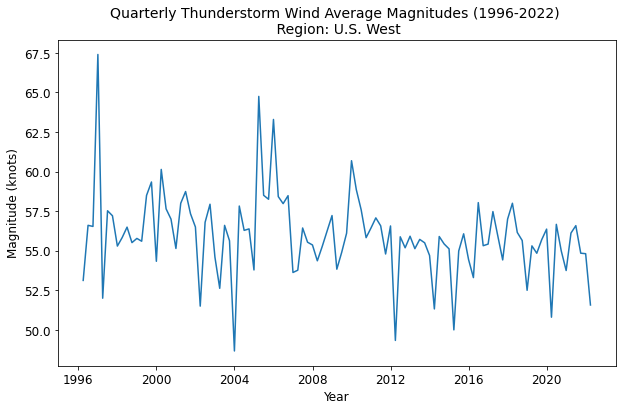

In [39]:
# Quarterly Thunderstorm Wind Average Magnitudes (1996-2022) - Region: U.S. West

plot_series(ts_wind, ['avg_mag'], title='Quarterly Thunderstorm Wind Average Magnitudes (1996-2022) \n Region: U.S. West', xlab='Year', ylab='Magnitude (knots)', steps=4)

---
## 4. Trends

### 4.1. Seasonality

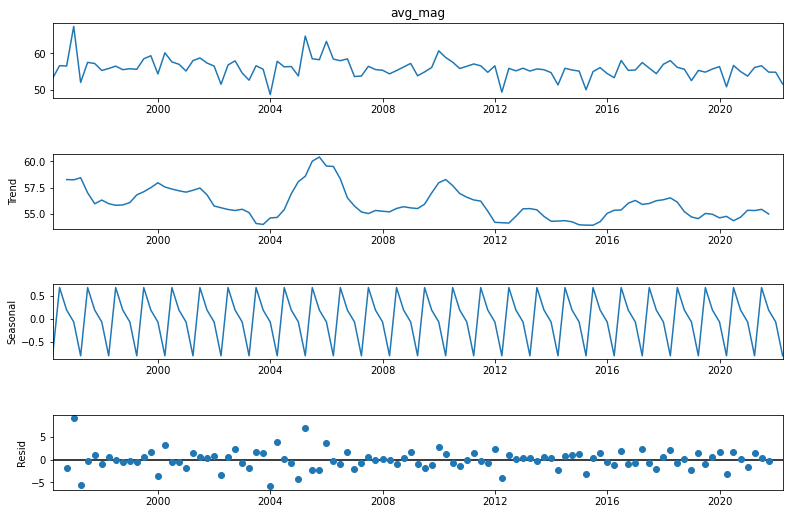

In [40]:
decomp = seasonal_decompose(ts_wind['avg_mag'])

decomp.plot();
fig = plt.gcf()
fig.set_size_inches(12, 8)

In the trend component, we see that the averages fluctuate quite a bit, but in general, we see a decrease over time.

In the seasonal component, we see that there appears to be some seasonality detected. But this seasonal view can sometimes be misleading, so I'll need to run some additional diagnostics.

In the resid component, we see that there's quite a bit of variability that can not be explained by the model.

### 4.2. Autocorrelation

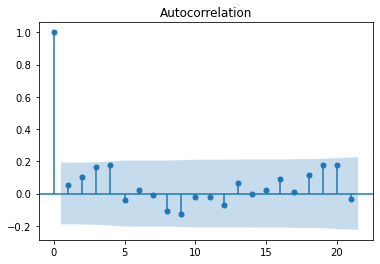

In [41]:
plot_acf(ts_wind['avg_mag']);

For trend, the lack of large and positive values in the earlier lags indicate and confirm that there is no real trend in the data.

For seasonality, the fluctuations do not occur with a fixed and known frequency and therefore, indicates that there is no seasonality in the data.

For lags, it seems that not using any will lead to best results, as no lags extend beyond the blue region.

### 4.3. Partial Autocorrelation

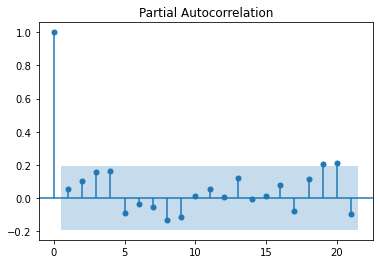

In [42]:
plot_pacf(ts_wind['avg_mag']);

For seasonality, as seen in the autocorrelation, the fluctuations do not occur with a fixed and known frequency and therefore, confirms that there is no seasonality present.

For lags, it still seems that not using any will lead to best results, as no lags extend beyond the blue region.

### 4.4. Stationarity

In [43]:
# Dickey-Fuller Stationarity Test

adfuller(ts_wind['avg_mag'])

(-3.522366071080831,
 0.007430925605259347,
 3,
 101,
 {'1%': -3.4968181663902103,
  '5%': -2.8906107514600103,
  '10%': -2.5822770483285953},
 424.55652743086046)

The first 2 statistics of the test result tell me that the data is indeed already stationary and that no differencing is required. The first statistic is the 'test statistic'. This value needs to be less than the critical values, which are the 1%, 5% and 10% values, and it is. The second statistic is the p-value, which needs to be less than the alpha of 0.05, and it is.

---
## 5. ARIMA Time Series Modeling

### 5.1. Train-Test Split

Considering the few observations that I have to work with, I'll be using 90% of the data to train on.

In [44]:
y_train, y_test = train_test_split(ts_wind['avg_mag'], test_size=0.1, shuffle=False)

### 5.2. GridSearch for best AIC, p & q

In [45]:
best_aic = 1_000_000_000
best_p = 0
best_q = 0

for p in range(5):
    for q in range(5):

        try:
            
            arima = ARIMA(endog = y_train.astype(float).dropna(),
                         order=(p, 0, q))
            
            model = arima.fit(method_kwargs={"warn_convergence": False})

            print(f'The AIC for ARIMA({p},0,{q}) is: {model.aic}')

            if model.aic < best_aic:
                best_aic = model.aic
                best_p = p
                best_q = q

        except Exception as e:
            print(e)
print()
print()
print('MODEL FINISHED!')
print(f'Our model that minimizes AIC on the training data is the ARIMA({best_p},0,{best_q}).')
print(f'This model has an AIC of {best_aic}.')

The AIC for ARIMA(0,0,0) is: 456.3183138280783
The AIC for ARIMA(0,0,1) is: 458.0827075265147
The AIC for ARIMA(0,0,2) is: 459.5682899941724
The AIC for ARIMA(0,0,3) is: 459.2014171683548
The AIC for ARIMA(0,0,4) is: 454.4662783511362
The AIC for ARIMA(1,0,0) is: 458.0400563502654
The AIC for ARIMA(1,0,1) is: 458.54971509864635
The AIC for ARIMA(1,0,2) is: 459.0276831921906


/Applications/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Applications/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


The AIC for ARIMA(1,0,3) is: 458.3812153522639
The AIC for ARIMA(1,0,4) is: 456.21018567539505
The AIC for ARIMA(2,0,0) is: 459.1916187420491
The AIC for ARIMA(2,0,1) is: 459.6411174928473
The AIC for ARIMA(2,0,2) is: 451.26982075438485
The AIC for ARIMA(2,0,3) is: 452.61384240071754
The AIC for ARIMA(2,0,4) is: 457.8985501154716
The AIC for ARIMA(3,0,0) is: 459.2925886984863
The AIC for ARIMA(3,0,1) is: 460.4093738246296
The AIC for ARIMA(3,0,2) is: 452.5899355627456
The AIC for ARIMA(3,0,3) is: 455.2500769284428
The AIC for ARIMA(3,0,4) is: 455.4036628054946
The AIC for ARIMA(4,0,0) is: 457.8773158875257
The AIC for ARIMA(4,0,1) is: 458.3482937712784
The AIC for ARIMA(4,0,2) is: 459.50735512793517
The AIC for ARIMA(4,0,3) is: 461.5000485362322
The AIC for ARIMA(4,0,4) is: 453.48313671286405


MODEL FINISHED!
Our model that minimizes AIC on the training data is the ARIMA(2,0,2).
This model has an AIC of 451.26982075438485.


The p, d, q combination that returned the lowest AIC was when p=2, d=0, and q=2. This means that the model will perform best with the use of 2 lags, no differencing and a moving average window of 2. This combination, referred to as an order,  will be referenced as (2,0,2) and will be used as the ARIMA model order parameter.

### 5.3. Instantiate & Fit

In [46]:
model = ARIMA(endog=y_train.astype(float).dropna(), order = (2,0,2))

arima = model.fit()

/Applications/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


### 5.4. Test Forecast

In [47]:
# Checking how many quarters were considered as test data with a test size of 10%

len(y_test)

11

In [48]:
# Generating the forecast for those 11 quarters

forecast = arima.forecast(steps=11)
forecast

2019-09-30    55.275881
2019-12-31    54.659063
2020-03-31    54.852316
2020-06-30    55.511624
2020-09-30    56.197458
2020-12-31    56.599032
2021-03-31    56.630161
2021-06-30    56.395487
2021-09-30    56.083381
2021-12-31    55.856158
2022-03-31    55.786853
Freq: Q-DEC, Name: predicted_mean, dtype: float64

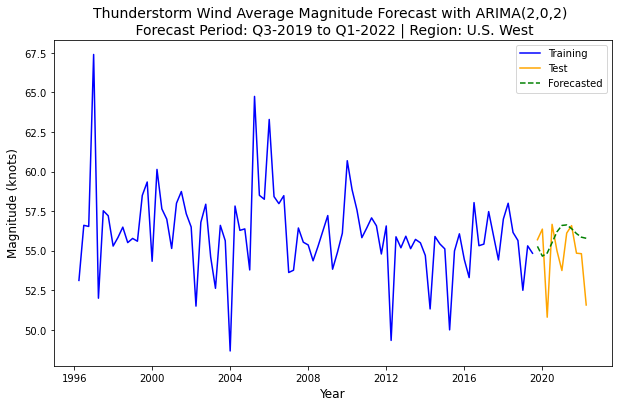

In [49]:
# Thunderstorm Wind Average Magnitude Forecast with ARIMA(2,0,2) - Forecast Period: Q3-2019 to Q1-2022 | Region: U.S. West

plt.figure(figsize=(10,6))
plt.plot(y_train.index, y_train, color='blue', label='Training')
plt.plot(y_test.index, y_test, color='orange', label='Test')
plt.plot(y_test.index, forecast, color='green', label='Forecasted', linestyle='--')

plt.title(label = 'Thunderstorm Wind Average Magnitude Forecast with ARIMA(2,0,2) \n Forecast Period: Q3-2019 to Q1-2022 | Region: U.S. West', fontsize=14)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Magnitude (knots)', fontsize=12)

plt.legend();

Visually, the model does not seem to have forecasted very well. It tries to follow some of the fluctuations, but sticks around the mean and does not catch the dips.

### 5.5. Test Evaluation

In [53]:
r2 = r2_score(y_test, forecast)
print('R2: ' + str(r2))

R2: -0.3040384983108173


The model does not do well at all in explaining the variability of the data, and explains why the model stuck close to predicting the mean.

In [51]:
# Root mean squared error

rmse = mean_squared_error(y_test, forecast, squared=False)
print('RMSE: ' + str(rmse))

RMSE: 2.155458672505572


In [52]:
ts_wind.describe()

,avg_mag
count,105.000000
mean,55.953798
std,2.656428
min,48.666667
25%,54.844633
50%,55.880184
75%,57.076923
max,67.400000


The RMSE of 2.16 did not exceed the standard deviation of 2.66. This model's forecasts are reliable by these evaluation metric's standards.